In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# changing the display so that the cells fill the whole window

In [3]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [4]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [5]:
def load_directory(path, file_types='All'):
    # getting files from a certain directory and selecting the data type such as source and wavelength
    # sourting them into a dictionary labeled by the file type
    files = {}
    
    file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"), reverse=True)[::-1] # sorting all of the files in the given directory
    print('Number of files found: ', len(file_list))
    for file in file_list:
        file_parts = file.split("_")
        try:
            file_wavelength = float(file_parts[-2]) # get wavelength from filename
        except ValueError:
            file_wavelength = file_parts[-2] # leaving tag as a string for source data
        if file_types == 'All': # loading all file types
            if file_wavelength not in files: # starting the dictionary of files according to type
                files[file_wavelength] = [file]
            else:
                files[file_wavelength].append(file)
    
        elif str(file_wavelength) in str(file_types): # loading only the specified file types
            if file_wavelength not in files: # starting the dictionary of files according to type
                files[file_wavelength] = [file]
            else:
                files[file_wavelength].append(file)
        else:
            pass
    
    if file_types == 'All': # printing the number of files in the directory
        print('Number of files: ', len(file_list))
    else:
        length = np.sum([len(each) for each in files.values()]) # getting the number of files of a specified type
        print('Number of files: ', length)
    
    return files

In [48]:
def peak_fit_srs10(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, peak_range=500):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    
    peaks_index, _ = scipy.signal.find_peaks(y_data, distance=min_distance)
    
    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    gain_info = [] # parameters to fit the gain
    peak_params = [] # parameters to plot the gaussian
    peak_number = 1 # corresponds to single photoelectron peak
    peaks = [] # list of where all the peaks are that are used in the fits
    peak_cuts = []
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        
        peaks.append(np.array([x_data[peak], y_data[peak]]))
        
        # initial guess for the Gaussian parameters
        amplitude_guess = y_data[peak]
        mean_guess = x_data[peak]
        standard_deviation_guess = 10
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # cutting data around each peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - 30))
        else:
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - peak_range))
        peak_x = x_data[cut] # x values of peak for fitting
        peak_y = y_data[cut] # y values of peak for fitting
        peak_cuts.append([peak_x, peak_y])
        
#         plt.yscale('log')
#         plt.plot(x_data[cut], y_data[cut], alpha=0.5)
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            # params are returned as amplitude, mean, std dev
#             print('Guess: ', initial_guess)
#             print('Params: ', params)
            peak_params.append(params)
            gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])]) # peak number, mean, and covariance
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            params = initial_guess
            peak_params.append(initial_guess)
            gain_info.append([peak_number, mean_guess, np.nan])
#             xx = np.linspace( x_data[peak] - 2*standard_deviation_guess, x_data[peak] + 2*standard_deviation_guess, 100 )
        
        peak_number += 1 # (goes to n*spe until it reaches max_peak)
        
    plt.show()
    return np.array(peak_params), np.array(gain_info), np.array(peaks), peak_cuts

In [7]:
def gain_fit(pe_locations):
    # fitting a line of the peak centers and heights to get the slope (gain) 
    fpts = ~np.isnan(pe_locations[:,1])
    if(np.sum(fpts) < 3):
        return
    # fitting the peak locations to a line to find the gain (slope)
    gain_bp, gain_bc = curve_fit(lin_fun, pe_locations[fpts, 0], pe_locations[fpts, 1])

    x = pe_locations[fpts, 0]
    
    return x, gain_bp, gain_bc

def find_bv(g_vs_v, wavelength):
    # finding the breakdown voltage using fitted gain data of a certain wavelength (310, 405, or source)
    data_to_use = np.asarray(g_vs_v[wavelength])
    
    # fitting the curve 
    bv_params, bv_cov = curve_fit(lin_fun, data_to_use[:, 0], data_to_use[:, 1], sigma=data_to_use[:, 2])
    
    return bv_params, bv_cov

In [43]:
def plot_fit_gain_dc(file, peak_dist, SRS_gain, binsize):
    # doing the gain calculations and plotting the results (hopefully store this in a separate script at some point)
    gain_vs_volts = {}
    print("Working on file %s"%(file))
    
    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data
    
    if (SRS_gain == 10):
    # setting the peak range for low gain data
        if file_volts < 31.5 and file_volts >=30.5:
            peak_range = 40 # picking a smaller range of values to fit over for the lower OV files
        elif file_volts < 30.5:
            print('low voltage range')
            peak_range = 25
        else:
            peak_range = 55
    elif (SRS_gain == 5):
        # setting the peak range for low gain data
        if file_volts < 31.5 and file_volts >=30.5:
            peak_range = 25 # picking a smaller range of values to fit over for the lower OV files
        elif file_volts < 30.5:
            print('low voltage range')
            peak_range = 20 # these might need changing
        else:
            peak_range = 45 # these might need changing
    
    # extracting the data from the files
    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, binsize) ## might add a conditional binsize once we figure out what that needs to be for each thing
    
    if SRS_gain == 10:
        # getting the peak and fit info
#         if file_wavelength == 'source':
        peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs10(b, c, file_volts, min_distance=peak_dist/2, min_thresh=5, peak_range=peak_range)
#         elif file_wavelength == 405.0:
#             peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs10(b, c, file_volts, min_distance=peak_dist/2, min_thresh=7, peak_range=peak_range, max_peaks=4)
#         elif file_wavelength == 310.0:
#             peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs10(b, c, file_volts, min_distance=peak_dist/2, min_thresh=7, peak_range=peak_range, max_peaks=3)
    elif SRS_gain == 5:
        # getting the peak and fit info
        if file_wavelength == 'source':
            peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs5(b, c, file_volts, min_distance=peak_dist*25/200, min_thresh=10, peak_range=peak_range)
        elif file_wavelength == 405.0:
            peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs5(b, c, file_volts, min_distance=peak_dist*25/200, min_thresh=10, peak_range=peak_range, max_peaks=4)
        elif file_wavelength == 310.0:
            peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs5(b, c, file_volts, min_distance=peak_dist*25/200, min_thresh=10, peak_range=peak_range, max_peaks=3)
    
    
    # starting the plots
    plt.figure(figsize=(18,6))
    
    # calculating and plotting the gain 
    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    xx, gain_params, gain_cov = gain_fit(pe_locs)
    gain_error = np.sqrt(np.diag(gain_cov))[0]
    plt.plot( xx, lin_fun(xx, *gain_params), 'r', label=r'Gain: %.2f $\pm$ %.2f'%(gain_params[0], gain_error))  #(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE'
    plt.legend()
    

    
    # plotting the peaks
    plt.subplot(1,2,1)
    plt.grid()
    plt.ylim(0.1, 8000)
    plt.yscale('log')
#     plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 1000)
#     plt.xticks(np.arange(0, 9, 1))
    
    plt.plot(b, c, 'k')
    plt.plot(peaks[:,0], peaks[:,1], 'o', color='r')
    for fit_params, data_peaks in zip(peak_info, data_for_fits):
        plt.plot(b, gauss_fun(b, *fit_params))
        plt.plot(data_peaks[0], data_peaks[1])
    plt.show()
    
    return b, c, gain_params[0], gain_error, gain_params[1], file_volts

# 0 E Field No Source

In [10]:
# getting the data that we need
path_4 = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step4/'
files_4 = load_directory(path_4)
SRS_gain_4 = 10 # gain on the SRS bandpass filter
# peak_threshold = 700 # upper bound of pedestal
# breakdown = 27.4 # breakdown voltage of the SiPM
pedestal_4 = 100 # center of noise pedestal peak

Number of files found:  2
Number of files:  2


Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step4/mca_keith_31.40OV_310_0.h5


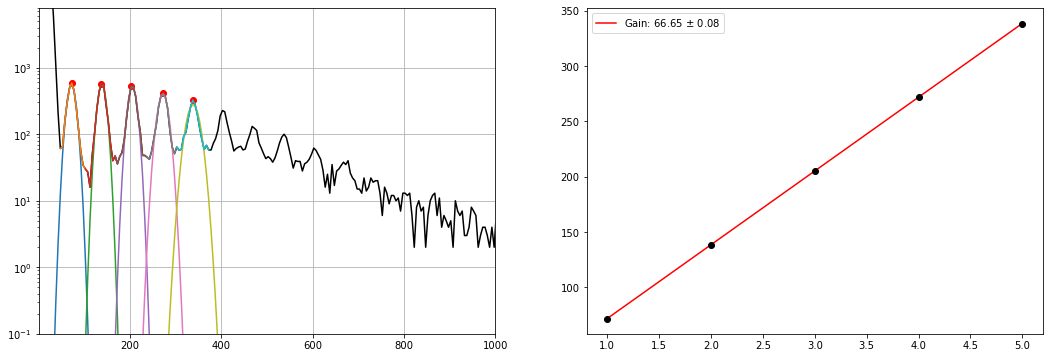

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step4/mca_keith_31.40OV_405_0.h5


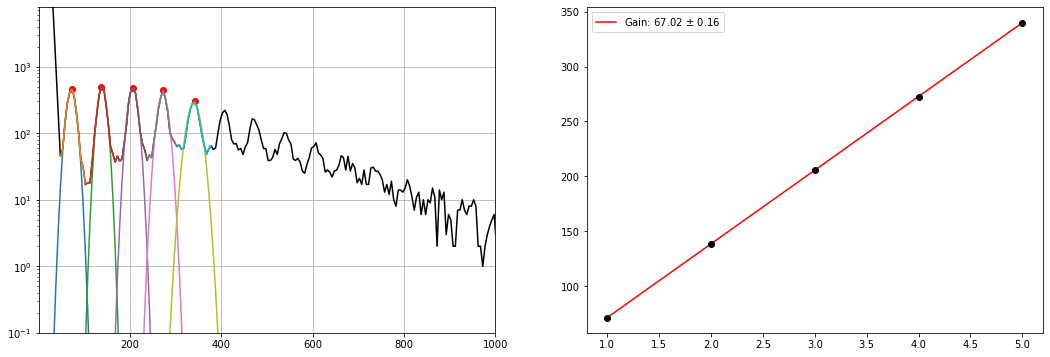

In [49]:
data_NO_FIELD1 = {'source':{}, 405.0:{}, 310.0:{}}

for file_type, file_list in files_4.items():
    # creating the data fields in the dict
    data_NO_FIELD1[file_type]['pe_data'] = []
    data_NO_FIELD1[file_type]['counts'] = []
    data_NO_FIELD1[file_type]['gain'] = np.empty(len(file_list))
    data_NO_FIELD1[file_type]['gain_err'] = np.empty(len(file_list))
    data_NO_FIELD1[file_type]['dc_offset'] = np.empty(len(file_list))
    data_NO_FIELD1[file_type]['file_volts'] = np.empty(len(file_list))
    for i, file in enumerate(file_list):
        pe, counts, gain, gain_err, dc_offset, volts = plot_fit_gain_dc(file, 20, 10, 5)
        data_NO_FIELD1[file_type]['pe_data'].append(pe)
        data_NO_FIELD1[file_type]['counts'].append(counts)
        data_NO_FIELD1[file_type]['gain'][i] = gain
        data_NO_FIELD1[file_type]['gain_err'][i] = gain_err
        data_NO_FIELD1[file_type]['dc_offset'][i] = dc_offset
        data_NO_FIELD1[file_type]['file_volts'][i] = volts
    # converting all the lists to arrays 
    data_NO_FIELD1[file_type]['pe_data'] = np.array(data_NO_FIELD1[file_type]['pe_data'])
    data_NO_FIELD1[file_type]['counts'] = np.array(data_NO_FIELD1[file_type]['counts'])

# 0 Field Source

In [12]:
# getting the data that we need
path_7 = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step7/'
files_7 = load_directory(path_7)
SRS_gain_7 = 10 # gain on the SRS bandpass filter
# peak_threshold = 700 # upper bound of pedestal
# breakdown = 27.4 # breakdown voltage of the SiPM
pedestal_7 = 100 # center of noise pedestal peak

Number of files found:  2
Number of files:  2


Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step7/mca_keith_31.40OV_310_0.h5


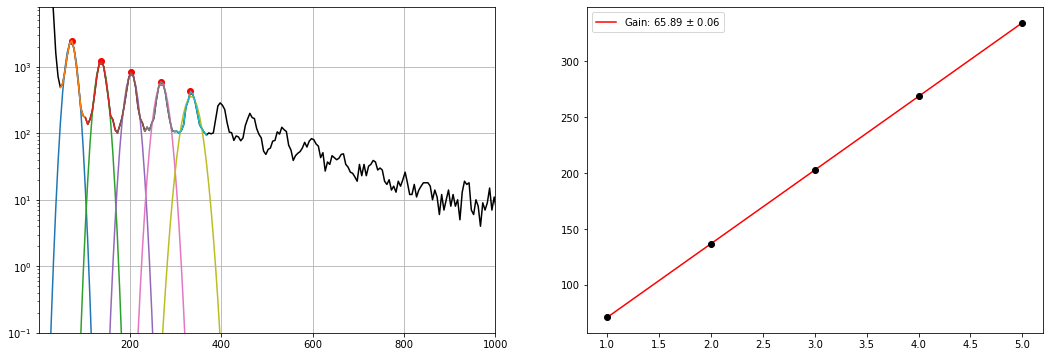

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230321/step7/mca_keith_31.40OV_405_0.h5


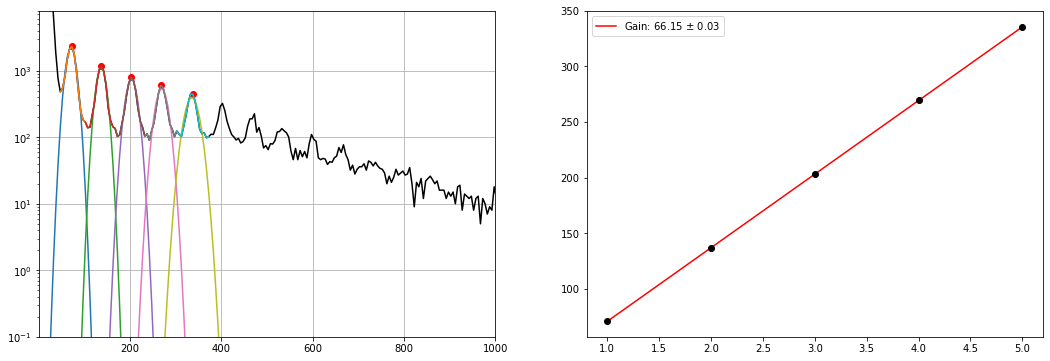

In [50]:
data_NO_FIELD2 = {'source':{}, 405.0:{}, 310.0:{}}

for file_type, file_list in files_7.items():
    # creating the data fields in the dict
    data_NO_FIELD1[file_type]['pe_data'] = []
    data_NO_FIELD1[file_type]['counts'] = []
    data_NO_FIELD1[file_type]['gain'] = np.empty(len(file_list))
    data_NO_FIELD1[file_type]['gain_err'] = np.empty(len(file_list))
    data_NO_FIELD1[file_type]['dc_offset'] = np.empty(len(file_list))
    data_NO_FIELD1[file_type]['file_volts'] = np.empty(len(file_list))
    for i, file in enumerate(file_list):
        pe, counts, gain, gain_err, dc_offset, volts = plot_fit_gain_dc(file, 20, 10, 5)
        data_NO_FIELD1[file_type]['pe_data'].append(pe)
        data_NO_FIELD1[file_type]['counts'].append(counts)
        data_NO_FIELD1[file_type]['gain'][i] = gain
        data_NO_FIELD1[file_type]['gain_err'][i] = gain_err
        data_NO_FIELD1[file_type]['dc_offset'][i] = dc_offset
        data_NO_FIELD1[file_type]['file_volts'][i] = volts
    # converting all the lists to arrays 
    data_NO_FIELD1[file_type]['pe_data'] = np.array(data_NO_FIELD1[file_type]['pe_data'])
    data_NO_FIELD1[file_type]['counts'] = np.array(data_NO_FIELD1[file_type]['counts'])